# RNN Language Model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from timeit import default_timer as timer

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
# P(x| w1, w2, .., wk)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
## Data from https://www.kaggle.com/datasets/auhide/bulgarian-poems/data
## Preprocessed data can be found in my github

In [8]:
with open("chitanka-corpus-prepared.txt", "r", encoding="utf8") as file:
    corpus = file.read()

In [9]:
print(corpus[:2000])

Христо Смирненски
Поема за руското дете
Далеч сред степите безбрежни
в порутен дом лежи дете;
навън виелицата снежна
безкраен бял саван плете.
А редом с болното детенце
простенва ссухрена жена
и взира се с печален поглед
през ледената тъмнина.
— Спи, късно е — му тя нашепва, —
навън се спуска черен мрак.
— Ах, винаги е късно зиме —
отвръща то и стене пак.
А тя му приказки разправя,
поглаждайки го със ръка,
за вещицата баба Яга
с дворец от кокоши крака,
за феята с коси зелени —
далеч там в мътните блата,
как с жабите ведно живее
и чудни песни пее тя…
И слуша бледото момиче
с разтворени от страх очи,
а вънка вихъра разбунен
напява гневно и бучи.
И сякаш някой черен призрак
се носи шеметно в нощта
и удря с вледенени пръсти
по заснежената врата.
А майката се моли тихо,
иконите зове без глас —
стои Исус там скръбнобледен,
с венец от злато и елмаз.
И шепне тя: „Исусе, чуй ме!
Детенцето ми ти спаси!
На таз земя сме всички братя,
а гладна смърт над нас виси.
Спаси ти мойта Василиса,
от глад сп

In [10]:
SPLIT_STRING = '@\n'
MAX_LEN = 2500
SYMBOL_MIN_COUNT = 100
AUTHOR_MIN_COUNT = 20

start_char = '{'
end_char = '}'
unk_char = '@'
pad_char = '|'
unk_author = '(неизвестен автор)'

In [15]:
def get_alphabet_authors(corpus):
    symbol2count={}
    author2count={}
    for author_poem in corpus:
        if len(author_poem) == 0:
            continue

        author_pos = author_poem.find('\n')
        author = author_poem[:author_pos]
        if author in author2count:
            author2count[author] += 1
        else:
            author2count[author] = 1
        poem = author_poem[author_pos+1:]

        for symbol in poem:
            if symbol in symbol2count:
                symbol2count[symbol] += 1
            else:
                symbol2count[symbol] = 1

    return symbol2count, author2count

def prepare_data(corpus, start_char=start_char, end_char=end_char, unk_char=unk_char, pad_char=pad_char):
    poems = corpus.split(SPLIT_STRING)
    symbol2count, author2count = get_alphabet_authors(poems)

    assert  start_char not in symbol2count and \
            end_char not in symbol2count and \
            unk_char not in symbol2count and \
            pad_char not in symbol2count

    charset = [start_char, end_char, unk_char, pad_char] +\
        [char for char in sorted(symbol2count) if symbol2count[char] > SYMBOL_MIN_COUNT]
    char2id = { char : id for id , char in enumerate(charset)}

    authset = [author for author in sorted(author2count) if author2count[author] > AUTHOR_MIN_COUNT]
    auth2id = { author : id for id, author in enumerate(authset)}

    auth_poem = []
    for i, s in enumerate(poems):
        if len(s) == 0:
            continue
        author_pos=s.find('\n')
        aut = s[:author_pos]
        poem = s[author_pos+1:]
        auth_poem.append( (aut, [start_char] + [ poem[i] for i in range(min(len(poem), MAX_LEN)) ] + [end_char]) )

    id2char  = {v: k for k, v in char2id.items()}
    id2auth = {v: k for k, v in auth2id.items()}

    train, val_test = train_test_split(auth_poem, test_size=0.2)
    test, val = train_test_split(val_test, test_size=0.5)

    return train, val, test, char2id, auth2id, id2char, id2auth

In [16]:
train, val, test, char2id, auth2id, id2char, id2auth =\
    prepare_data(corpus)

In [17]:
start_char_id = char2id[start_char]
end_char_id = char2id[end_char]
unk_char_id = char2id[unk_char]
pad_char_id = char2id[pad_char]
unk_author_id = auth2id[unk_author]

In [18]:
print(train[0])

('Хайнрих Хайне', ['{', 'Г', 'д', 'е', ' ', 'е', ' ', 'т', 'в', 'о', 'я', 'т', 'а', ' ', 'л', 'ю', 'б', 'и', 'м', 'а', '…', '\n', 'Г', 'д', 'е', ' ', 'е', ' ', 'т', 'в', 'о', 'я', 'т', 'а', ' ', 'л', 'ю', 'б', 'и', 'м', 'а', ',', '\n', 'щ', 'о', ' ', 'в', 'ъ', 'з', 'п', 'я', ' ', 'б', 'е', 'з', 'к', 'р', 'а', 'й', 'н', 'о', ' ', 'н', 'е', 'ж', 'н', 'о', '\n', 'н', 'я', 'к', 'о', 'г', 'а', ',', ' ', 'к', 'о', 'г', 'а', 'т', 'о', ' ', 'п', 'л', 'а', 'м', 'н', 'а', '\n', 'т', 'в', 'о', 'е', 'т', 'о', ' ', 'с', 'ъ', 'р', 'ц', 'е', ' ', 'м', 'е', 'т', 'е', 'ж', 'н', 'о', '?', '\n', 'С', 'т', 'у', 'д', ' ', 'и', ' ', 'м', 'р', 'а', 'к', ' ', 'е', ' ', 'в', 'ъ', 'в', ' ', 'с', 'ъ', 'р', 'ц', 'е', 'т', 'о', '\n', 'и', ' ', 'у', 'г', 'а', 'с', 'н', 'а', ' ', 'о', 'н', 'з', 'и', ' ', 'п', 'л', 'а', 'м', 'ъ', 'к', ',', '\n', 'т', 'а', 'з', 'и', ' ', 'к', 'н', 'и', 'ж', 'к', 'а', ' ', 'е', ' ', 'с', 'ъ', 'с', 'ъ', 'д', 'а', '\n', 'с', ' ', 'п', 'е', 'п', 'е', 'л', 'т', 'а', ' ', 'о', 'т', ' ', 'л'

In [20]:
def tokenize_text(text, char2id=char2id, unk_token_id=unk_char_id):
    result = []

    for char in text:
        result.append(char2id.get(char, unk_token_id))

    return result

In [22]:
# tokenize_text(train[0][1])

In [23]:
def tokenize_author_and_text(auth_text, char2id=char2id, auth2id=auth2id, unk_token_id=unk_char_id, unk_author_id=unk_author_id):
    authors = []
    poems = []

    for (author, poem) in auth_text:
        authors.append(auth2id.get(author, unk_char_id))
        poems.append(tokenize_text(poem, char2id=char2id, unk_token_id=unk_token_id))

    return authors, poems


In [24]:
def decode_texts(tokens, id2char=id2char, unk_char_id=unk_char_id):
    result = []

    for token in tokens:
        result.append(id2char.get(token, unk_char_id))

    return ''.join(result[1:-1])

In [25]:
len(char2id)

116

In [26]:
len(auth2id)

125

In [27]:
auth2id

{'(неизвестен автор)': 0,
 'Александър Блок': 1,
 'Александър Радонов': 2,
 'Ана Ахматова': 3,
 'Ангел Попов': 4,
 'Ангелина Жекова': 5,
 'Арсений Тарковски': 6,
 'Артюр Рембо': 7,
 'Асен Босев': 8,
 'Асен Разцветников': 9,
 'Атанас Далчев': 10,
 'Бертолт Брехт': 11,
 'Борис Пастернак': 12,
 'Боян Бойчев': 13,
 'Валери Видас': 14,
 'Валери Иванов': 15,
 'Веса Паспалеева': 16,
 'Веселин Ханчев': 17,
 'Виктор Юго': 18,
 'Владислав Ходасевич': 19,
 'Габриела Цанева': 20,
 'Галина Златина': 21,
 'Гео Милев': 22,
 'Георги Струмски': 23,
 'Георги Щерев': 24,
 'Гюнтер Кунерт': 25,
 'Дамян Дамянов': 26,
 'Деница Минчева': 27,
 'Джани Родари': 28,
 'Джордж Байрон': 29,
 'Дилън Томас': 30,
 'Димитър Бояджиев': 31,
 'Димитър Донев': 32,
 'Димчо Дебелянов': 33,
 'Дора Габе': 34,
 'Евтим Евтимов': 35,
 'Едгар Алън По': 36,
 'Езра Паунд': 37,
 'Екатерина Ненчева': 38,
 'Елин Пелин': 39,
 'Елисавета Багряна': 40,
 'Емили Дикинсън': 41,
 'Живко Лазаров': 42,
 'Змей Горянин': 43,
 'Иван Бунин': 44,
 'И

In [28]:
VOCAB_SIZE = len(char2id)
AUTH_SIZE = len(auth2id)
VOCAB_SIZE, AUTH_SIZE

(116, 125)

In [29]:
train_author, train_tokenized = tokenize_author_and_text(train, char2id=char2id, auth2id=auth2id, unk_token_id=unk_char_id, unk_author_id=unk_author_id)
val_author, val_tokenized = tokenize_author_and_text(val, char2id=char2id, auth2id=auth2id, unk_token_id=unk_char_id, unk_author_id=unk_author_id)
test_author, test_tokenized = tokenize_author_and_text(test, char2id=char2id, auth2id=auth2id, unk_token_id=unk_char_id, unk_author_id=unk_author_id)

In [30]:
print(train_tokenized[0])

[0, 54, 84, 85, 5, 85, 5, 98, 82, 94, 109, 98, 80, 5, 91, 108, 81, 88, 92, 80, 115, 4, 54, 84, 85, 5, 85, 5, 98, 82, 94, 109, 98, 80, 5, 91, 108, 81, 88, 92, 80, 10, 4, 105, 94, 5, 82, 106, 87, 95, 109, 5, 81, 85, 87, 90, 96, 80, 89, 93, 94, 5, 93, 85, 86, 93, 94, 4, 93, 109, 90, 94, 83, 80, 10, 5, 90, 94, 83, 80, 98, 94, 5, 95, 91, 80, 92, 93, 80, 4, 98, 82, 94, 85, 98, 94, 5, 97, 106, 96, 102, 85, 5, 92, 85, 98, 85, 86, 93, 94, 26, 4, 68, 98, 99, 84, 5, 88, 5, 92, 96, 80, 90, 5, 85, 5, 82, 106, 82, 5, 97, 106, 96, 102, 85, 98, 94, 4, 88, 5, 99, 83, 80, 97, 93, 80, 5, 94, 93, 87, 88, 5, 95, 91, 80, 92, 106, 90, 10, 4, 98, 80, 87, 88, 5, 90, 93, 88, 86, 90, 80, 5, 85, 5, 97, 106, 97, 106, 84, 80, 4, 97, 5, 95, 85, 95, 85, 91, 98, 80, 5, 94, 98, 5, 91, 108, 81, 94, 82, 98, 80, 5, 92, 88, 12, 4, 1]


In [31]:
print(decode_texts(train_tokenized[0], id2char))

Где е твоята любима…
Где е твоята любима,
що възпя безкрайно нежно
някога, когато пламна
твоето сърце метежно?
Студ и мрак е във сърцето
и угасна онзи пламък,
тази книжка е съсъда
с пепелта от любовта ми.



## Data generator

In [33]:
def data_generator(poem, author, batch_size=32, shuffle_data=True, pad_token_id=pad_char_id):

    if shuffle_data:
        poem, author = shuffle(poem, author)

    n_batches = int(np.ceil(len(author) / batch_size))

    for batch in range(n_batches):
        end = min((batch + 1) * batch_size, len(author))

        X_poem = poem[batch * batch_size:end]
        X_author = author[batch * batch_size:end]

        max_len = np.max([len(x) for x in X_poem])
        for sample in range(len(X_poem)):
            x = X_poem[sample]
            pad = [pad_char_id] * (max_len - len(x))
            X_poem[sample] = pad + x

        X_poem = torch.from_numpy(np.array(X_poem)).long()
        X_author = torch.from_numpy(np.array(X_author)).long()

        yield X_poem, X_author

In [35]:
lens = [len(el) for el in train_tokenized]
np.mean(lens), np.max(lens), np.percentile(lens, 95)

(np.float64(683.725), np.int64(2502), np.float64(1899.0499999999993))

In [36]:
train_gen   = lambda : data_generator(train_tokenized, train_author, batch_size=32)
val_gen     = lambda : data_generator(val_tokenized, val_author, batch_size=32, shuffle_data=False)
test_gen    = lambda : data_generator(test_tokenized, test_author, batch_size=32, shuffle_data=False)

In [ ]:
# the dog was angry <end>
# the dog was angry
# dog was angry <end>

In [38]:
def train_step(model, data_loader, loss_fn, optimizer, device):

    model.train()

    train_loss = 0
    steps = 0

    for X_poem, X_author in data_loader():
        X_poem, X_author = X_poem.to(device), X_author.to(device)
        y_pred, (h_out, c_out) = model(X_poem[:, :-1], X_author)

        # X_poem[:, 1:].shape: [n_samples, max_seq_len - 1]
        # y_pred.shape: [n_samples, max_seq_len - 1, vocab_size]
        # but PyTorch expects [n_samples, vocab_size, max_seq_len - 1]
        loss = loss_fn(y_pred.transpose(2, 1), X_poem[:, 1:])
        # this is an inefficient way to calculate the loss
        # later we will see how to do it more efficiently
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()
        steps += 1

    return train_loss / steps


def test_step(model, data_loader, loss_fn, device):

    model.eval()

    test_loss = 0
    steps = 0

    with torch.inference_mode():
        for X_poem, X_author in data_loader():

            X_poem, X_author = X_poem.to(device), X_author.to(device)

            y_pred, (h_out, c_out) = model(X_poem[:, :-1], X_author)
            # X_poem[:, 1:].shape: [n_samples, max_seq_len - 1]
            # y_pred.shape: [n_samples, max_seq_len - 1, vocab_size]
            # but PyTorch expects [n_samples, vocab_size, max_seq_len - 1]
            loss = loss_fn(y_pred.transpose(2, 1), X_poem[:, 1:])

            test_loss += loss.item()
            steps += 1

    return test_loss / steps

def train(model,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn,
          epochs,
          device):

    results = {
        "train_loss": [],
        "test_loss": [],
        }

    model.to(device)

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss = train_step(
            model=model,
            data_loader=train_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        end_time = timer()

        test_loss = test_step(
            model=model,
            data_loader=test_data_loader,
            loss_fn=loss_fn,
            device=device,
        )

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"time: {(end_time-start_time):.4f}"
        )

    return results

def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]


    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()


## RNN

In [41]:
class RNN(nn.Module):
    def __init__(self, n_vocab, n_author, embed_dim, hidden_size, n_layers, dropout=0):
        super(RNN, self).__init__()
        self.V = n_vocab
        self.n_author = n_author
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.out_dim = n_vocab

        self.embed = nn.Embedding(self.V, self.embed_dim)
        self.embed_author = nn.Embedding(self.n_author, self.n_layers * self.hidden_size)

        self.rnn = nn.LSTM(
            input_size=self.embed_dim,
            hidden_size=self.hidden_size,
            num_layers=self.n_layers,
            batch_first=True,
            bidirectional=False,
            dropout=dropout
        )

        self.fc = nn.Linear(hidden_size, self.out_dim)


    def forward(self, x, author):
        # x.shape [n_samples, max_seq_len]

        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)
        # h0.shape = c0.shape: [n_layers, n_samples, hidden_size]
        x = self.embed(x.to(torch.int64))
        author_embed = self.embed_author(author.to(torch.int64))\
            .view(self.n_layers, x.size(0), self.hidden_size).to(device)
        # author.shape = c0.shape: [n_layers, n_samples, hidden_size]
        # x.shape [n_samples, max_seq_len, embed_dim]
        x, (h_out, c_out) = self.rnn(x, (h0, author_embed))
        # x.shape [n_samples, max_seq_len, hidden_size]

        x = self.fc(x)
        # x.shape [n_samples, max_seq_len, vocab_size]

        return x, (h_out, c_out)

In [42]:
VOCAB_SIZE

116

In [43]:
rnn_model = RNN(n_vocab=VOCAB_SIZE, n_author=len(auth2id), embed_dim=VOCAB_SIZE, hidden_size=384, n_layers=3, dropout=0.5).to(device)

print(rnn_model)

loss = nn.CrossEntropyLoss(ignore_index=pad_char_id)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=2e-3)

RNN(
  (embed): Embedding(116, 116)
  (embed_author): Embedding(125, 1152)
  (rnn): LSTM(116, 384, num_layers=3, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=384, out_features=116, bias=True)
)


In [76]:
num_params = sum(p.numel() for p in rnn_model.parameters() if p.requires_grad)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8183 | test_loss: 2.2127 | time: 254.3411
Epoch: 2 | train_loss: 2.0868 | test_loss: 1.9063 | time: 280.0004
Epoch: 3 | train_loss: 1.9077 | test_loss: 1.7897 | time: 284.1423
Epoch: 4 | train_loss: 1.8215 | test_loss: 1.7254 | time: 281.6934
Epoch: 5 | train_loss: 1.7681 | test_loss: 1.6810 | time: 285.7929
Epoch: 6 | train_loss: 1.7284 | test_loss: 1.6493 | time: 285.1974
Epoch: 7 | train_loss: 1.6990 | test_loss: 1.6253 | time: 283.4276
Epoch: 8 | train_loss: 1.6761 | test_loss: 1.6060 | time: 284.0975
Epoch: 9 | train_loss: 1.6577 | test_loss: 1.5915 | time: 285.4896
Epoch: 10 | train_loss: 1.6419 | test_loss: 1.5780 | time: 282.7392


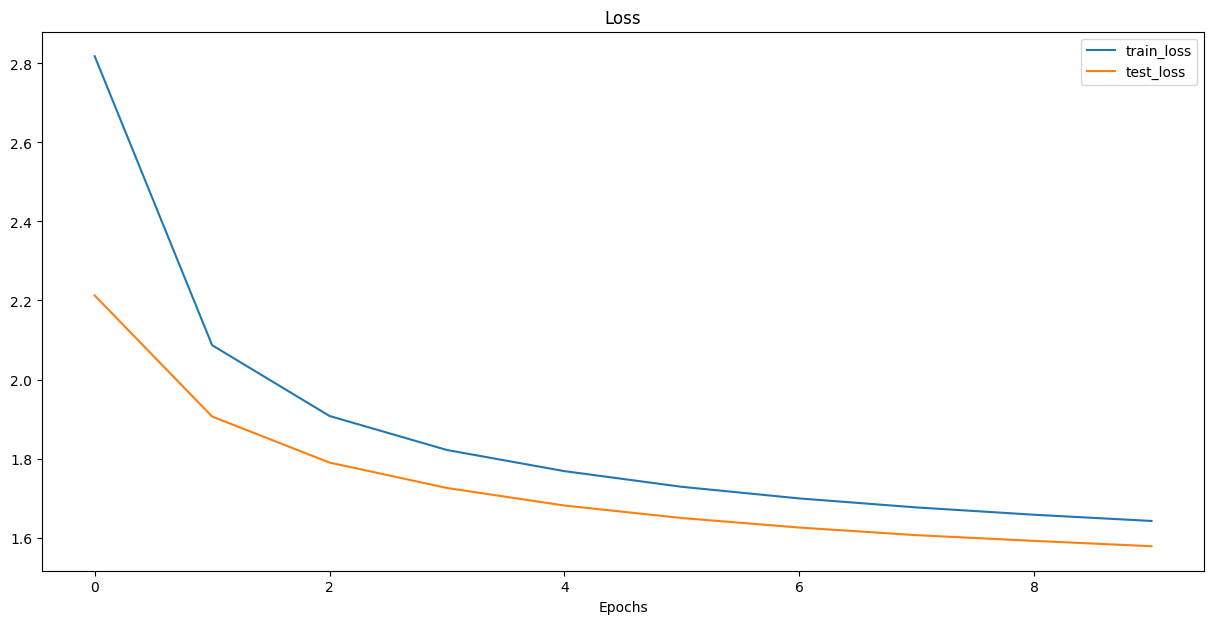

In [ ]:
results = train(model=rnn_model,
          train_data_loader = train_gen,
          test_data_loader = val_gen,
          optimizer = optimizer,
          loss_fn = loss,
          epochs = 10,
          device = device)

plot_loss_curves(results)

In [67]:
import numpy as np
np.exp(1.5780)

np.float64(4.845255603056542)

## Testing

In [45]:
def generate(model, prompt="", author="(неизвестен автор)", max_len=1000, temperature=0.4):
    result = prompt
    num_symbols = len(char2id)

    tokens = tokenize_text(start_char + prompt, char2id=char2id, unk_token_id=unk_char_id)
    output, (h, c) = model(torch.tensor([tokens]).to(device), torch.tensor(auth2id[author]).to(device))
    # output.shape [1, seq_len, vocab_size]
    y = output[:, -1, :][0]
    # 7.shape [1, 1, vocab_size]
    distribution = torch.nn.functional.softmax(y / temperature, dim=0)
    next_symbol_index = np.random.choice(num_symbols, p=distribution.cpu().detach().numpy())
    next_symbol = id2char[next_symbol_index]
    result += next_symbol

    while len(result) < max_len and next_symbol != end_char:
        symbol = torch.tensor([next_symbol_index], dtype=torch.long, device=device)
        symbol_embed = model.embed(symbol)
        output, (h_new, c_new) = model.rnn(symbol_embed, (h.squeeze(1), c.squeeze(1)))
        output = model.fc(output)
        y = output[0]
        # print(y.shape)
        distribution = torch.nn.functional.softmax(y / temperature, dim=0)

        next_symbol_index = np.random.choice(num_symbols, p=distribution.cpu().detach().numpy())
        next_symbol = id2char[next_symbol_index]
        result += next_symbol
        (h, c) = (h_new, c_new)

    return result


In [ ]:
torch.save(rnn_model, 'rnn_poet.pt')

In [46]:
rnn_model = torch.load('rnn_poet.pt', map_location=torch.device(device), weights_only=False)

In [48]:
print(generate(rnn_model))

Полетни пътища
В полята на слънцето на себе си
и ти се върна в поглед на света.
Всичко се следе в тебе си отдалече
и се скрива в нея се случи се става.
Пристигнаха ме с обич се възпитание,
от страх и слънчев за пристигнали с безброй,
там се подслужавам се по моята празна,
и светът не може да се откъсне,
ти си под него се любима с кръв и свят.
Но аз се подслужи в бездните на косите
ми се разбира на своя този дум на света,
където да показва в болката на преди,
със свойта своя си съдба на подставила мисли,
от него все те става се в мене и се противя.
}


In [ ]:
auth2id

{'(неизвестен автор)': 0,
 'Александър Блок': 1,
 'Александър Радонов': 2,
 'Ана Ахматова': 3,
 'Ангел Попов': 4,
 'Ангелина Жекова': 5,
 'Арсений Тарковски': 6,
 'Артюр Рембо': 7,
 'Асен Босев': 8,
 'Асен Разцветников': 9,
 'Атанас Далчев': 10,
 'Бертолт Брехт': 11,
 'Борис Пастернак': 12,
 'Боян Бойчев': 13,
 'Валери Видас': 14,
 'Валери Иванов': 15,
 'Веса Паспалеева': 16,
 'Веселин Ханчев': 17,
 'Виктор Юго': 18,
 'Владислав Ходасевич': 19,
 'Габриела Цанева': 20,
 'Галина Златина': 21,
 'Гео Милев': 22,
 'Георги Струмски': 23,
 'Георги Щерев': 24,
 'Гюнтер Кунерт': 25,
 'Дамян Дамянов': 26,
 'Деница Минчева': 27,
 'Джани Родари': 28,
 'Джордж Байрон': 29,
 'Дилън Томас': 30,
 'Димитър Бояджиев': 31,
 'Димитър Донев': 32,
 'Димчо Дебелянов': 33,
 'Дора Габе': 34,
 'Евтим Евтимов': 35,
 'Едгар Алън По': 36,
 'Езра Паунд': 37,
 'Екатерина Ненчева': 38,
 'Елин Пелин': 39,
 'Елисавета Багряна': 40,
 'Емили Дикинсън': 41,
 'Живко Лазаров': 42,
 'Змей Горянин': 43,
 'Иван Бунин': 44,
 'И

In [ ]:
print(generate(rnn_model, prompt="", author="Атанас Далчев", max_len=1000, temperature=0.4))

Падат ли стихотворението на Ангелите на колата на простора на простора на морето се оставя до страстта на простора на последната си повече на дървото, което спокойно от своя подмет на своя стих от свойта песен на получистите си от полето пред престинали стихотворение на света на твоя пристъп полето се слуша.
}


In [ ]:
print(generate(rnn_model, prompt="Камък ", author="Атанас Далчев", max_len=1000, temperature=0.4))

Камък на Превода
Сега е той е на смъртта.
Пред париж без смърт, какво за нея става
под твойта сърце на света си светлина,
но по своя свят търси от светлината.
И не ще се спомнят се на него със света,
пристъпи се се въздушно се подскача.
Под моите простори последни дни.
}


In [ ]:
print(generate(rnn_model, prompt="Камък ", author="Иван Вазов", max_len=1000, temperature=0.4))

Камък до своя свят
Понованият в тъмната си прага
на сърцето на себе си в тях
под болка не се оставя на своя свят
и се по-любов и светлина на своя ден.
Какво е те на твойто дете не се открива,
и който да те се подсмискваш се в него
и в твоята простора на песента ми е не беше ти
и пак ще познава в свойта страна на свойта песен.
И сега си там, че си да се случи по тебе се видя,
а пък е сред тях червената нощ на утрото,
на съня на моя странна страх ще се усмивка
и сега не спира в свойто странно моя свят.
}


In [ ]:
print(generate(rnn_model, prompt="Трамвай ", author="Атанас Далчев", max_len=1000, temperature=0.4))

Трамвай по нашия при безумния
Бог аз съм по стария ден на своя за камък на парата
и в своя свят на хората на своя свят на своя страна на дървото,
когато си познавам по звездите на този път и в небето,
и колко се покрива в тебе стъпките на странния пет,
от небето и от младостта и последната разбирам
и светлината на нея направил в очите,
да се пристане с очите ми да стане в своята волна,
но в твоята страна на света на полустоящите си диви,
и се вдигам се с мен ще се страшни, ще откъсна самотността,
и с тази душа на своята къща на гордостта на светлината
на душата покрива в светлината и мислите на мене.
}


In [ ]:
print(generate(rnn_model, prompt="Пайторч ", author="Христо Фотев", max_len=10000, temperature=0.3))

Пайторч Ангел
Като простиране на приятелите
и в представа пред небето си страх
и с вечността на пролетта на света
и се простори с корони и червени
с последни безкрайни полети и се откриват.
По страх на светлината на мойто песен
с под него се прости се на всички страни,
но не се пристъпи в сърцето ми подава.
Но не са видяха по своя стъпки през мене,
когато се последни под своя град небето,
и с приятелството на оня свят на своята светлина
и в полята си се просторе в света на света.
}


In [ ]:
print(generate(rnn_model, prompt="Факултет по математика и информатика ", author="Христо Фотев", max_len=10000, temperature=0.3))

Факултет по математика и информатика в пролет
Пред своята градина на всички страни
и по полето се прости се по светлината,
на полята на своя стая се случи.
После в света на себе си последна светлина,
не е светлината на своя свят на света,
от светлината на тебе си преди страшно.
В светлината на своя си странен син на душата
и с тревожни светлина, с други светлини,
в своя свят с вечер при теб се въздуха сини,
по своята своя безпомня се със света.
Но той си през него се възпирам на света,
когато се подсмива се в своя полета.
Но не зная с тебе се познава да се видя,
а не се открива на небесата си,
но не се видя в свойта светлина и скръб.
И тъй да се върна с този свят и светлина,
не съм се направя под тебе ще се върне.
И все пристигна се със своя свят да се разбира,
но да се познавам да последни да се върна.
}


In [ ]:
print(generate(rnn_model, prompt="Факултет по математика и информатика ", author="Христо Ботев", max_len=10000, temperature=0.6))

Факултет по математика и информатика и се може болитерно с прахове и копита, с очите красиви скристи.
Пред пазителния пере в пристигнали вече,
която се смъртени се случи и последните милиони.
И всичко си може би е на всички страните на реките
и страшно се преваря в сърцето на пушка.
И само там в мене не убивам стъпките на всичко,
изплетял да остане в небесната лице
с мен и от светлината, която ви не спря ти станаха.
Той поглежда с твоите чудни.
Всичко се спаси своя бог.
Страхувам като никога ти дари на мигом си,
за да ме е всеки миг е разсъмване.
}


In [53]:
print(generate(rnn_model, prompt="Колега ще се видим септември ", author="Гео Милев", max_len=1000, temperature=0.4))

Колега ще се видим септември и под светлината на преди в преди през 1919 г. с непредишно в подсемителната душа на постоянно се обичам от безсънните думи на Санталия и на преставането на своя свят и стари през стари прозорци. В престолите на подводната от страната на Констинистов при това се презира в простора на последната през въздуха на воля на мъртвите на покой се изправя с това и полето и черните стени на презизолни покриви на полето на старото се пристъпи.
}


In [60]:
september = '''Нощта ражда из мъртва утроба
вековната злоба на роба:
своя пурпурен гняв -
величав.

Дълбоко сред мрак и мъгла.


Из тъмни долини
- преди да се съмне
из всички балкани
из дебри пустинни
из гладни поля
из кални паланки
села
градове
дворове
из хижи, колиби
из фабрики, складове, гари
хамбари
чифлици
воденици
работилници
юзини
заводи:'''

In [63]:
print(generate(rnn_model, prompt=september, author="Гео Милев", max_len=10000, temperature=0.01))

Нощта ражда из мъртва утроба
вековната злоба на роба:
своя пурпурен гняв -
величав.

Дълбоко сред мрак и мъгла.


Из тъмни долини
- преди да се съмне
из всички балкани
из дебри пустинни
из гладни поля
из кални паланки
села
градове
дворове
из хижи, колиби
из фабрики, складове, гари
хамбари
чифлици
воденици
работилници
юзини
заводи:
— Какво е той се спряло,
но не се спря с тебе,
но не се преди да се преди да се спря.
}
